In [1]:
include("D:\\Julia\\dqmc_fsj\\lattice_model.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_parameters.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_fields.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_matrix_cdw_channel.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_stable.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_eqlt_greens.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_update.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_helper.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_ueqlt_greens.jl")

get_uneqlt_greens (generic function with 1 method)

In [2]:
Lx = 6;
Ly = 6;
betas = [2.0, 4.0, 5.0, 6.0, 7.0, 8.0]
mu = 0.0
t = 1.0;
Hubbard_U = 4.0

beta = betas[1]
thermal_sweeps = 1000
meas_sweeps = 1000

1000

In [3]:
tri_lat = Triangular_Lattice(Lx, Ly)
tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
parameters = dqmc_parameters(beta=beta)
hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
stack = dqmc_matrices_stack_real_qr(tri_model, parameters)
    
build_udt_stacks_modified!(hs_field, stack)
copyto!(stack.u_stack[1], I)
stack.d_stack[1] .= one(Float64)
copyto!(stack.t_stack[1], I);

In [4]:
# 热化
thermalization_sweeps(hs_field, stack, thermal_sweeps)

In [5]:
# 测试uniform magnetic susceptibility
bins_sdz = zeros(Float64, meas_sweeps)

for sweep_idx in 1:meas_sweeps
    sweep_up_local_modified!(hs_field, stack)
    sweep_down_local_modified!(hs_field, stack)
    # println(hs_field.accepted_ratio)
    
    stack.current_range = 1
    G00 = similar(stack.greens)
    copyto!(G00, stack.greens)
    get_greens_temp_modified!(stack, G00)
    Gll = similar(stack.greens)
    copyto!(Gll, stack.greens)
    Gl0 = similar(stack.greens)
    copyto!(Gl0, stack.greens)
    G0l = similar(stack.greens)
    G0l = Gll - I

    dims = stack.dims
    U_tmp = Matrix{Float64}(I, dims, dims)
    D_tmp = ones(Float64, dims)
    T_tmp = Matrix{Float64}(I, dims, dims)
    
    # 先计算一下τ=0的情形
    sdz_00 = zero(Float64)
    n_sites = tri_lat.sites
    for site1 = 1:n_sites, site2 = 1:n_sites
        if site1 == site2
            sdz_00 += (1 - G0l[site1,site1]) * Gl0[site1,site1] + (1 - G0l[site1,site1]) * Gl0[site1, site1]
        else
            sdz_00 += - 2 * G00[site2,site1] * G00[site1,site2]
        end
    end
    
    for slice in 1:stack.n_slices
        get_uneqlt_greens(stack, hs_field, Gll, Gl0, G0l, U_tmp, D_tmp, T_tmp, slice, dims)
        get_greens_temp_modified!(stack, Gll)
        get_greens_temp_modified!(stack, Gl0)
        get_greens_temp_modified!(stack, G0l)
        
        n_sites = Lx * Ly
#         sdz_00 = zero(Float64)
        for site1 = 1:n_sites, site2 = 1:n_sites
            sdz_00 += - 2 * G0l[site2,site1] * Gl0[site1,site2]
        end
    end
    
    sdz_00 = sdz_00 * parameters.delta_tau / (n_sites^2)
    bins_sdz[sweep_idx] = sdz_00
    stack.current_range = 1
    copyto!(stack.Ur, stack.u_stack[1])
    copyto!(stack.Dr, stack.d_stack[1])
    copyto!(stack.Tr, stack.t_stack[1])

    copyto!(stack.Ul, I)
    stack.Dl = ones(Float64, dims)
    copyto!(stack.Tl, I)
    
    copyto!(stack.u_stack[1], I)
    stack.d_stack[1] = ones(Float64, dims)
    copyto!(stack.t_stack[1], I)
end

In [6]:
sdz_av = sum(bins_sdz) / meas_sweeps
sdz_error = Float64(0.0)
@turbo for bin_index in 1:meas_sweeps
    sdz_error += (bins_sdz[bin_index] - sdz_av) ^ 2
end
sdz_error = sdz_error / sqrt((tri_lat.sites - 1)*tri_lat.sites)

7.970679138434373e-6

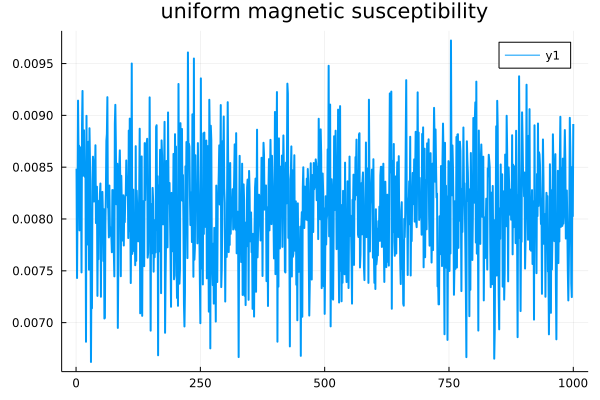

In [7]:
using Plots
plot(bins_sdz,linewidth=2,title="uniform magnetic susceptibility")

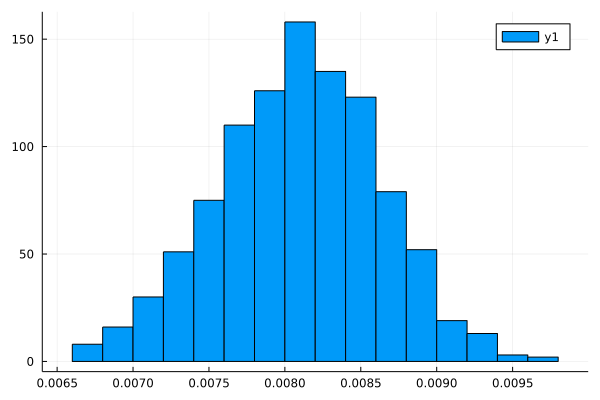

In [8]:
histogram(bins_sdz)

In [9]:
sum(bins_sdz) / meas_sweeps

0.008093249613633832

In [10]:
betas = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

sdz_meas = zeros(Float64, 8)
sdz_errors = zeros(Float64, 8)

for (index, beta) in enumerate(betas)
    Lx = 6
    Ly = 6
    mu = 0.0
    t = 1.0
    Hubbard_U = 4.0

    thermal_sweeps = 1000
    meas_sweeps = 1000
    tri_lat = Triangular_Lattice(Lx, Ly)
    tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
    parameters = dqmc_parameters(beta=beta)
    hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
    stack = dqmc_matrices_stack_real_qr(tri_model, parameters)

    build_udt_stacks_modified!(hs_field, stack)
    copyto!(stack.u_stack[1], I)
    stack.d_stack[1] .= one(Float64)
    copyto!(stack.t_stack[1], I);

    thermalization_sweeps(hs_field, stack, thermal_sweeps)
    
    bins_sdz = zeros(Float64, meas_sweeps)
    
    for sweep_idx in 1:meas_sweeps
        
        sweep_up_local_modified!(hs_field, stack)
        sweep_down_local_modified!(hs_field, stack)
        # println(hs_field.accepted_ratio)
        dims = stack.dims
        
        # 先计算平均占据数
        stack.current_range = 1
        G00 = similar(stack.greens)
        copyto!(G00, stack.greens)
        get_greens_temp_modified!(stack, G00)
        
        Gll = similar(stack.greens)
        copyto!(Gll, stack.greens)
        Gl0 = similar(stack.greens)
        copyto!(Gl0, stack.greens)
        G0l = similar(stack.greens)
        G0l = Gll - I

        U_tmp = Matrix{Float64}(I, dims, dims)
        D_tmp = ones(Float64, dims)
        T_tmp = Matrix{Float64}(I, dims, dims)

        # 先计算一下τ=0的情形
        sdz_00 = zero(Float64)
        n_sites = tri_lat.sites
        for site1 = 1:n_sites, site2 = 1:n_sites
            if site1 == site2
                sdz_00 += (1 - G00[site1,site1]) * G00[site1,site1] + (1 - G00[site1,site1]) * G00[site1, site1]
            else
                sdz_00 += - 2 * G00[site2,site1] * G00[site1,site2]
            end
        end

        for slice in 1:stack.n_slices
            get_uneqlt_greens(stack, hs_field, Gll, Gl0, G0l, U_tmp, D_tmp, T_tmp, slice, dims)
            get_greens_temp_modified!(stack, Gll)
            get_greens_temp_modified!(stack, Gl0)
            get_greens_temp_modified!(stack, G0l)

            n_sites = Lx * Ly
    #         sdz_00 = zero(Float64)
            for site1 = 1:n_sites, site2 = 1:n_sites
                sdz_00 += - 2 * G0l[site2,site1] * Gl0[site1,site2]
            end
        end

        sdz_00 = sdz_00 * parameters.delta_tau / (n_sites)
        bins_sdz[sweep_idx] = sdz_00
        
        stack.current_range = 1
        copyto!(stack.Ur, stack.u_stack[1])
        copyto!(stack.Dr, stack.d_stack[1])
        copyto!(stack.Tr, stack.t_stack[1])

        copyto!(stack.Ul, I)
        stack.Dl = ones(Float64, dims)
        copyto!(stack.Tl, I)

        copyto!(stack.u_stack[1], I)
        stack.d_stack[1] = ones(Float64, dims)
        copyto!(stack.t_stack[1], I)
    end
    
    sdz_av = sum(bins_sdz) / meas_sweeps
    sdz_meas[index] = sdz_av
    
    sdz_error = Float64(0.0)
    @turbo for bin_index in 1:meas_sweeps
        sdz_error += (bins_sdz[bin_index] - sdz_av) ^ 2
    end
    sdz_error = sdz_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    sdz_errors[index] = sdz_error
    
end


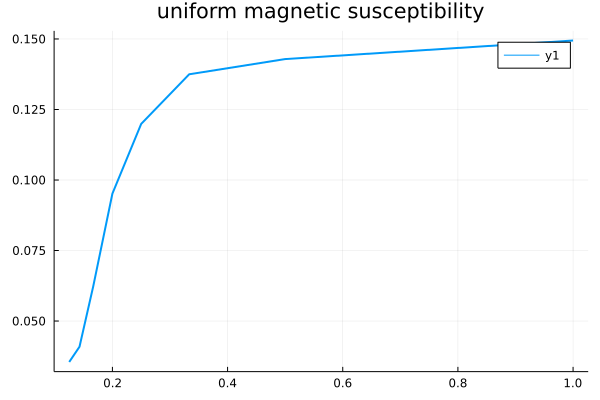

In [11]:
temperature = 1 ./ betas
plot(temperature, sdz_meas,linewidth=2,title="uniform magnetic susceptibility")

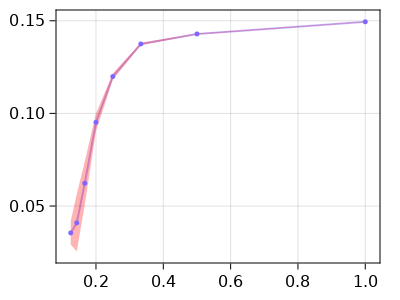

In [12]:
using CairoMakie, Colors
CairoMakie.activate!()
fig = Figure(figure_padding = (10, 20, 10, 10), resolution = (400, 300))
ax = Axis(fig[1, 1])

c = HSV(250, 0.6, 1)
lines!(ax, temperature, sdz_meas, color = (c, 0.5), linewidth=2)
band!(ax, temperature, sdz_meas - sdz_errors, sdz_meas + sdz_errors, color = (:red, 0.3))
CairoMakie.scatter!(ax, temperature, sdz_meas, color = c, markersize = 5.0)
current_figure()

In [13]:
q1 = vcat(range(Float64[0, 0],   Float64[pi, 0], length=10))
display(q1)

10-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.3490658503988659, 0.0]
 [0.6981317007977318, 0.0]
 [1.0471975511965976, 0.0]
 [1.3962634015954636, 0.0]
 [1.7453292519943295, 0.0]
 [2.0943951023931953, 0.0]
 [2.443460952792061, 0.0]
 [2.792526803190927, 0.0]
 [3.141592653589793, 0.0]

In [14]:
q1[3][2]

0.0